## Random Forest

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import os
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

En preprocess_signal no hay mucho que comentar, simplemente sale un vector con las características de la señal.

Respecto a Load Signal:

Cuando se trabaja en Deep Learning, la entrada de datos es diferentes, me puse a dividir los datos entre entrenamiento/Test/Validación de manera manual, pero me he dado cuenta de que realmente no vale para nada, porque hace una división aleatoria en la carga de archivos, por lo menos según la configuración que tengo ahora.

In [2]:
def preprocess_signal(signal):

    # Parámetros teóricos
    max_theoretical_value = 230 * np.sqrt(2)

    # Media de la señal
    mean_value = np.mean(signal)

    # Datos sin sesgo
    unbias_data = signal - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    # Cálculo de características
    variance = np.var(unbias_data)  # Varianza
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)  # Asimetría
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3  # Curtosis
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal)[2:4])) / np.abs(np.fft.fft(signal)[1]))  # Distorsión armónica total
    rms = np.sqrt(np.mean(signal ** 2))  # Valor RMS
    crest_factor = np.max(signal) / rms  # Factor de cresta

    # Devuelve todas las características en un vector
    return np.array([variance, skewness, kurtosis, thd, crest_factor])

def load_signal(data_path):

    # Asignar etiquetas explícitamente
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signals": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
        "harmonic_sag_signals": 7,
    }

    # Inicialización de listas para características y etiquetas
    features = []
    labels = []

    # Iterar por cada tipo de perturbación.
    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)

        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)

                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)

                            # Cargar la señal
                            signal = np.load(file_path)

                            # Procesar la señal y extraer características
                            feature_vector = preprocess_signal(signal)

                            # Agregar las características y etiquetas a las listas
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Ejemplo de uso
data_path = "data"  # Ajusta esta ruta según sea necesario
features, labels = load_signal(data_path)

print(f"Características extraídas: {features.shape}")
print(f"Etiquetas extraídas: {labels.shape}")


# Contar las etiquetas únicas en los datos originales 
unique_labels, counts = np.unique(labels, return_counts=True)
print("Etiquetas únicas:", unique_labels)
print("Distribución de señales por categoría:")
for label, count in zip(unique_labels, counts):
    print(f"Clase {label}: {count} señales")

# He tenido problemas a la hora de cargar los datos, en ocasiones no cargaba la variable 3 y se creaba la 7.
# Es una flag.
if 3 not in unique_labels: 
    print("Error: La clase 3 no está presente en los datos originales.")

Características extraídas: (86400, 5)
Etiquetas extraídas: (86400,)
Etiquetas únicas: [0 1 2 3 4 5 6 7]
Distribución de señales por categoría:
Clase 0: 10800 señales
Clase 1: 10800 señales
Clase 2: 10800 señales
Clase 3: 10800 señales
Clase 4: 10800 señales
Clase 5: 10800 señales
Clase 6: 10800 señales
Clase 7: 10800 señales


Para explicar el código quiero ir línea por línea y explicar que hace cada celda.

En la primera línea tenemos la básica para cargar los datos, donde repartimos los datos de entrenamiento y test.

train_test_splits:
1. features porque son las entradas que se dan iniciales a partir de los datos.
2. labels son las salidas, que lo convierte en un sistema multiclase (8 en este momento)
3. stratify=labels, hace que el reparto de clases sea proporcional si los conjunto de datos están desbalanceados, en este caso en cada clase tenemos 10800 muestras y no sería estrictamente necesario ponerlo, pero lo pongo para que no se me olvide cuando haga el cruce con datos externos que estén desbalanceados.
4. test_size=0.2, 80% train, 20% test
5. random_state=1, simplemente se le da un número para que cada vez que itere con distintos hiperparámetros, los datos sean los mismos.

En el futuro, cuando se quiera cruzar datos con datos externos que no sean los del experimento habrá que evitar el train_test_splits.

1. X_train serán los datos actuales, en este caso será el vector de características "feature" que se extraen directamente del subprograma anterior.
2. X_test serán los datos cruzados, será el vector de caracteristicas "feature_2" que se extraerán de otro subprograma.
3. y_train es el vector de clases, deberá coincidir con el numero tipos de datos que hay en el modelo.
4. y_pred será la predicción.

In [3]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels ,test_size=0.2, random_state=1)

# Crear el modelo base
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo de Random Forest: {accuracy:.2f}")

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Accuracy del modelo de Random Forest: 0.98

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2160
           1       0.97      0.97      0.97      2160
           2       0.95      1.00      0.98      2160
           3       1.00      1.00      1.00      2160
           4       0.96      0.95      0.95      2160
           5       0.99      0.99      0.99      2160
           6       1.00      1.00      1.00      2160
           7       0.98      0.95      0.96      2160

    accuracy                           0.98     17280
   macro avg       0.98      0.98      0.98     17280
weighted avg       0.98      0.98      0.98     17280



Además de obtener una predicción, y ver como se comporta el modelo, a través de la librería "seaborn" podemos graficar el la matriz de confusión que nos diga donde hay confusión en los datos a la hora de clasificarse.

Recordando la clasificación de las clases:

1. Flicker
2. Harmónico
3. Interrupción
4. Señal Original
5. Sag
6. Swell
7. Transitorios
8. Harmonico+Sag

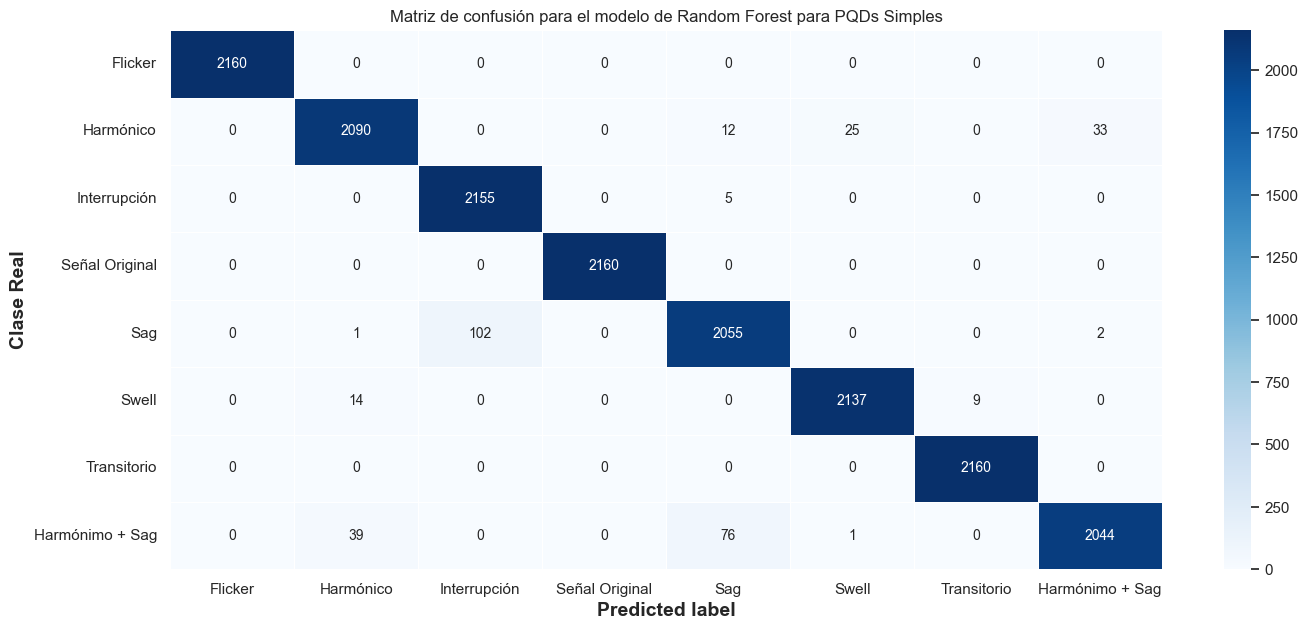

In [5]:
# Se tiene que haber cargado "confusion_matrix" desde scikit_Learn
matrix = confusion_matrix(y_test, y_pred)

# La mejor dimensión que he encontrado para que se muestre es 16x7, menor se solapan los nombres
plt.figure(figsize=(16,7))
# Simplemente dejar la escala de la fuente en un número que no sea demasiado grande
sns.set(font_scale=1)
# importante fmt = 'd', si no, lo valores se mostrarán porcentualmente. cmap Blues porque me gusta el azul.
sns.heatmap(matrix, annot=True, annot_kws={'size':10},fmt= 'd' ,cmap=plt.cm.Blues, linewidths=0.5)

# Add labels to the plot
class_names = ['Flicker', 'Harmónico', 'Interrupción', 'Señal Original', 'Sag', 'Swell','Transitorio',"Harmónimo + Sag"]
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', weight='bold', fontsize=14)
plt.ylabel('Clase Real', weight='bold', fontsize=14)
plt.title('Matriz de confusión para el modelo de Random Forest para PQDs Simples')
plt.show()